# Implementing quantum channels in a quantum computer using smaller registers

__Implementation of quantum channels using smaller ancillas (i.e. a smaller quantum register) by factorizing the target quantum channel in Kraus deficient channels__

In this notebook I constructed quantum circuits to simulate two singular quantum channels using a register size smaller than the one dictated by the [__Stinespring theorem__](https://www.quantiki.org/wiki/church-larger-hilbert-space). For qubit channels, the environment 

$$\mathcal{E}[\rho]=\sum_{i=1}^{d^2}{K_i \rho K_i^\dagger{}}$$

<img src="images/circuit.jpeg" width="400" class="center">

## Functions and libraries needed

In [52]:
# Importing libraries for the construction of the quantum circuit
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister, execute
# Importing also numpy, will be needed later
import numpy as np

In [ ]:
#Loading account
from qiskit import IBMQ
provider = IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

In [ ]:
# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
from qiskit.tools.monitor import job_monitor

## Constructing circuits for the implementation of total depolarizing channel

In [8]:
#Creation of quantum and classical registers and putting them together
q = QuantumRegister(2)
c = ClassicalRegister(1)
qc=QuantumCircuit(q,c)

I define below the unitaries that are going to implement each part of our channel

In [9]:
U=[[0,0,0,1],
   [0,1,0,0],
   [0,0,1,0],
   [1,0,0,0]
  ]
U2=[[1,0,0,0],
   [0,2**-0.5,2**-0.5,0],
   [0,2**-0.5,-2**-0.5,0],
    [0,0,0,1]
   ]
U3=[[0,0,1,0],
   [2**-0.5,0,0,2**-0.5],
   [-2**-0.5,0,0,2**-0.5],
    [0,1,0,0]
   ]

In [10]:
qc.unitary(U,[0,1],'$U_{boundary}$')
qc.measure(0,0)
qc.unitary(U2,[0,1],'$U_{e^{\mathcal{L}}}$').c_if(c, 0)
qc.unitary(U3,[0,1],'$U{\prime}_{e^{\mathcal{L}}}$').c_if(c, 1)

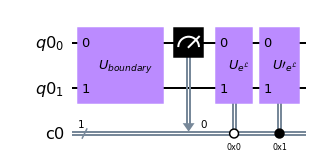

In [11]:
qc.draw('mpl')

_Transpiling_ the circuit so that it can be implemented in the quantum computer. This process is made by IBM anyway.

In [82]:
trans_qc=transpile(qc,basis_gates=['cx','u3','u','cz'],optimization_level=3)

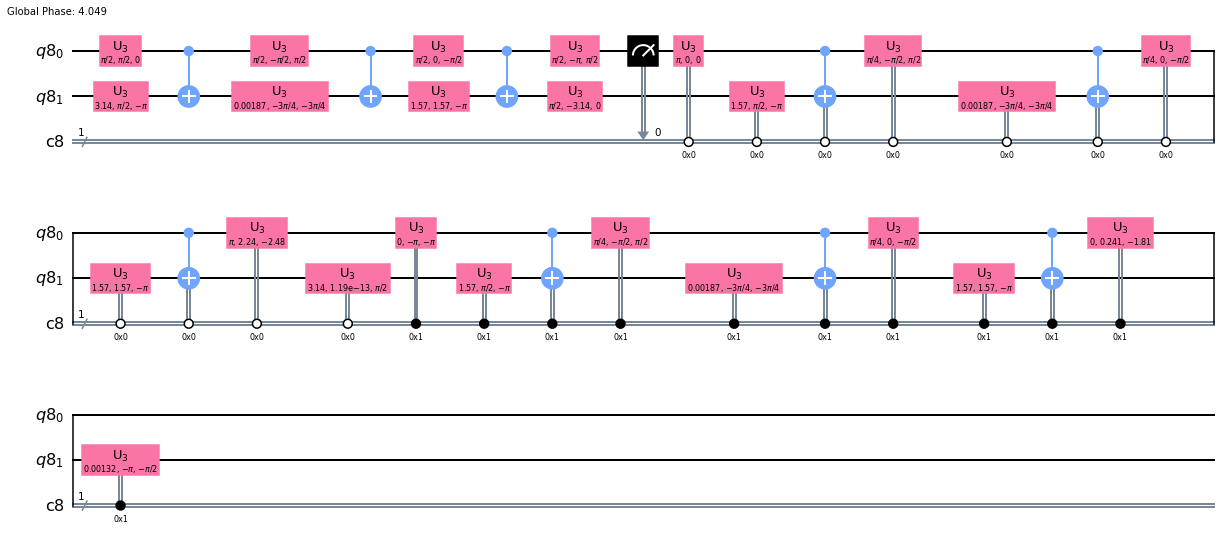

In [83]:
trans_qc.draw('mpl')

### Quantum process tomography

First we start session in IBM Quantum

Quantum process tomography is the procedure to 

In [96]:
backend='ibmq_manila'
quamtum_computer= provider.get_backend(backend)

In [91]:
qpt_circs = process_tomography_circuits(trans_qc,q[1],prepared_qubits=q[1])

In [97]:
job = execute(qpt_circs,backend=quamtum_computer, shots=10000)

job_monitor(job)

Job Status: job incurred error     


In [93]:
qpt_tomo_comp = ProcessTomographyFitter(job.result(), qpt_circs)

IBMQJobFailureError: 'Unable to retrieve result for job 62811f3548360a1e37542be4. Job has failed: Instruction bfunc is not supported. Error code: 7001.'

Unfortunately the used IBM 5-qubit computers don not support unitary gates controlled by bits. To overcome this and still prove the concept, we use the principle of [deferred measurement](https://en.wikipedia.org/wiki/Deferred_Measurement_Principle). This is, basically we will use a quantum bit as a classical bit, but to avoid unnecessary operations (for instance a SWAP to always use the same qubit as classical qubit), we simply use the first environmental qubit as a quantum control for the second stage.

# Using deferred measurement example 1

In [ ]:
qc.unitary(U,[0,1],'$U_{boundary}$')
qc.measure(0,0)
qc.unitary(U2,[0,1],'$U_{e^{\mathcal{L}}}$').c_if(c, 0)
qc.unitary(U3,[0,1],'$U{\prime}_{e^{\mathcal{L}}}$').c_if(c, 1)

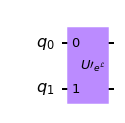

In [13]:
qc1=QuantumCircuit(2)
qc1.unitary(U2,[0,1],'$U_{e^{\mathcal{L}}}$')
qc2=QuantumCircuit(2)
qc2.unitary(U3,[0,1],'$U{\prime}_{e^{\mathcal{L}}}$')
qc2.draw('mpl')

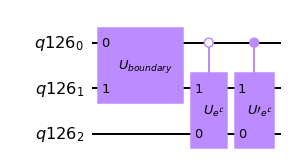

In [31]:
q = QuantumRegister(3)
qc=QuantumCircuit(q)
qc.unitary(U,[0,1],'$U_{boundary}$')
cU1=qc1.to_gate(label='$U_{e^{\mathcal{L}}}$').control(1,ctrl_state=0)
qc.append(cU1,[0,2,1])
cU1=qc2.to_gate(label='$U{\prime}_{e^{\mathcal{L}}}$').control(1,ctrl_state=1)
qc.append(cU1,[0,2,1])
qc.draw('mpl')
#qc.unitary(U3,[0,1]).c_if(c, 1)

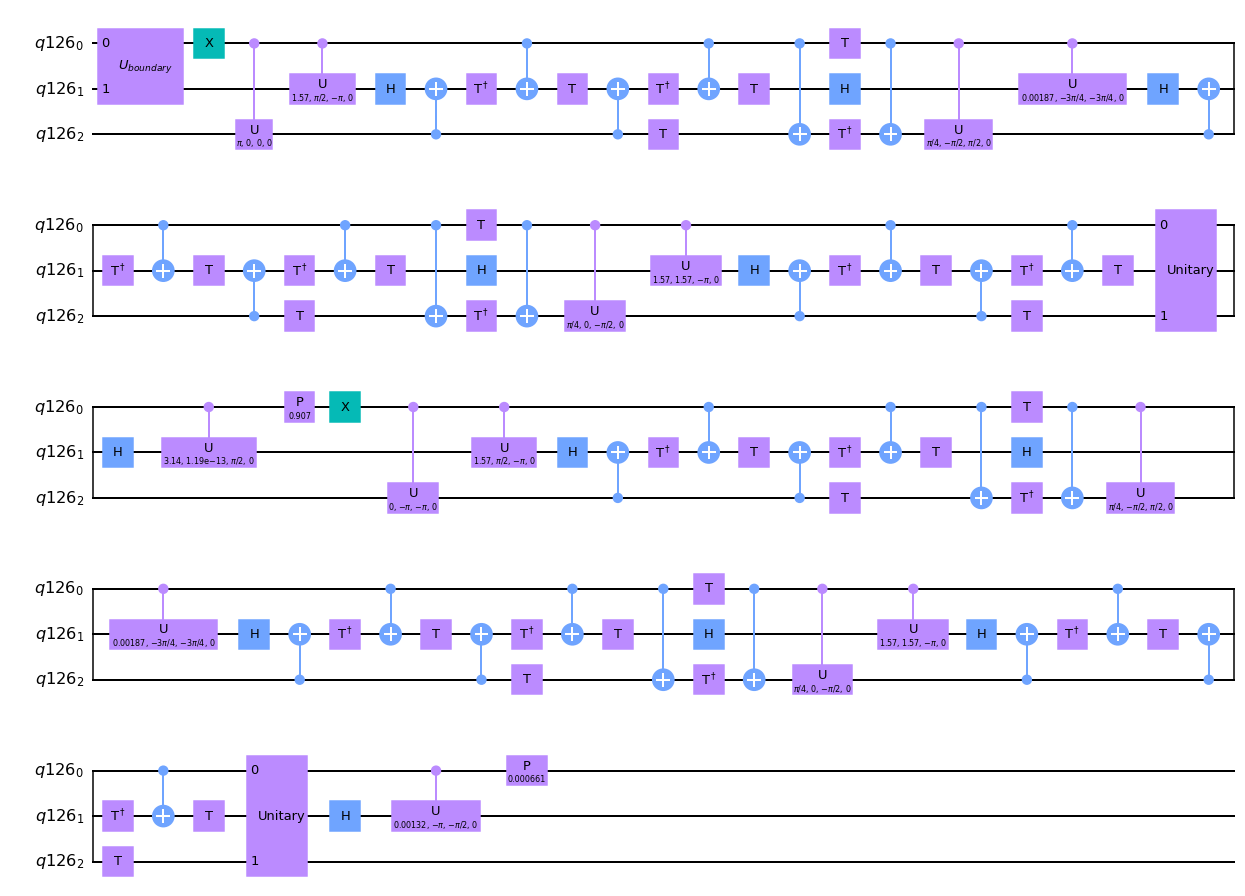

In [32]:
qc_transpiled=transpile(qc,optimization_level=3)
qc_transpiled.draw('mpl')

### Quantum process tomography

In [46]:
backend='ibmq_quito'
quamtum_computer= provider.get_backend(backend)

In [47]:
qpt_circs = process_tomography_circuits(qc,q[1],prepared_qubits=q[1])

In [45]:
# list(map(lambda r: r.draw(),qpt_circs)) Print list of quantum process tomography circuit

In [48]:
job = execute(qpt_circs,backend=quamtum_computer, shots=20000)

job_monitor(job)

Job Status: job has successfully run


In [49]:
qpt_tomo_comp = ProcessTomographyFitter(job.result(), qpt_circs)

In [50]:
choi=qpt_tomo_comp.fit()

In [53]:
print(np.round(choi,3))

[[ 0.607+0.j     0.033+0.015j  0.007-0.028j -0.008+0.027j]
 [ 0.033-0.015j  0.393+0.j    -0.063+0.003j -0.007+0.028j]
 [ 0.007+0.028j -0.063-0.003j  0.561+0.j     0.045+0.014j]
 [-0.008-0.027j -0.007-0.028j  0.045-0.014j  0.439+0.j   ]]


In [58]:
theoreticalchoi=np.diag(0.5*np.array([1,1,1,1]))

# Using deferred measurement example 2

In [312]:
U=[[0,0,1,0],
   [0,1,0,0],
   [1,0,0,0],
   [0,0,0,1]
  ]
l=0.5
gm=(1-l)**0.5/(2**0.5)
gp=(1+l)**0.5/(2**0.5)
U2=[[0,gm,0,-gp],
   [gm,0,-gp,0],
   [gp,0,gm,0],
    [0,gp,0,gm]]
U3=[[0,-gp,0,gm],
   [-gp,0,gm,0],
   [gm,0,gp,0],
     [0,gm,0,gp]]

In [313]:
qc1=QuantumCircuit(2)
qc1.unitary(U2,[0,1])
qc2=QuantumCircuit(2)
qc2.unitary(U3,[0,1])
qc2.draw()

┌──────────┐
q_0: ┤0         ├
     │  Unitary │
q_1: ┤1         ├
     └──────────┘

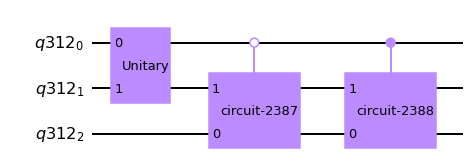

In [314]:
q = QuantumRegister(3)
qc=QuantumCircuit(q)
qc.unitary(U,[0,1])
cU1=qc1.to_gate().control(1,ctrl_state=0)
qc.append(cU1,[0,2,1])
cU1=qc2.to_gate().control(1,ctrl_state=1)
qc.append(cU1,[0,2,1])
qc.draw('mpl')
#qc.unitary(U3,[0,1]).c_if(c, 1)

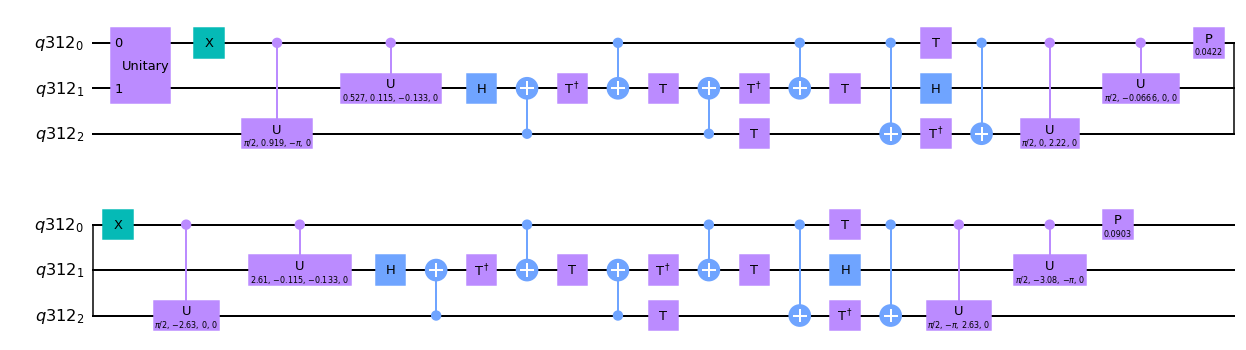

In [315]:
qc_transpiled=transpile(qc,optimization_level=3)
qc_transpiled.draw('mpl')

### Quantum process tomography

In [316]:
backend='ibmq_lima'
quamtum_computer= provider.get_backend(backend)

In [317]:
qpt_circs = process_tomography_circuits(qc,[1],prepared_qubits=[1])

In [319]:
job = execute(qpt_circs,backend=quamtum_computer, shots=20000)

job_monitor(job)

Job Status: job has successfully run


In [320]:
qpt_tomo_comp = ProcessTomographyFitter(job.result(), qpt_circs)

In [321]:
choi=qpt_tomo_comp.fit()

In [322]:
print(np.round(choi,3))

[[ 0.735+0.j     0.043-0.038j -0.297-0.072j  0.066+0.079j]
 [ 0.043+0.038j  0.265+0.j    -0.108-0.101j  0.297+0.072j]
 [-0.297+0.072j -0.108+0.101j  0.374+0.j     0.015-0.055j]
 [ 0.066-0.079j  0.297-0.072j  0.015+0.055j  0.626+0.j   ]]


# Testing ordering

In [84]:
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister, execute
from qiskit.circuit.gate import Gate

In [85]:
U=[[0,0,0,1],
   [0,1,0,0],
   [0,0,1,0],
   [1,0,0,0]
  ]

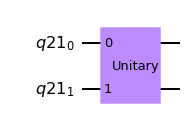

In [86]:
q = QuantumRegister(2)
qc=QuantumCircuit(q)
qc.unitary(U,[0,1])
qc.draw('mpl')

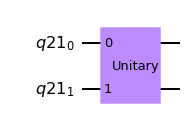

In [87]:
qc_transpiled=transpile(qc,optimization_level=3)
qc_transpiled.draw('mpl')

### Quantum process tomography

In [88]:
# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
from qiskit.tools.monitor import job_monitor

/tmp/ipykernel_317152/3764712384.py:2: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


In [5]:
# Setting provider
backend='ibmq_quito'
quamtum_computer= provider.get_backend(backend)

In [304]:
qpt_circs = process_tomography_circuits(qc,[0],prepared_qubits=[0])

In [305]:
job = execute(qpt_circs,backend=quamtum_computer, shots=20000)

job_monitor(job)

Job Status: job has successfully run


In [306]:
qpt_tomo_comp = ProcessTomographyFitter(job.result(), qpt_circs)

In [307]:
choi=qpt_tomo_comp.fit()

In [308]:
print(np.round(choi,3))

[[ 0.083+0.j     0.018+0.023j -0.002-0.004j  0.072-0.089j]
 [ 0.018-0.023j  0.917+0.j    -0.033+0.033j  0.002+0.004j]
 [-0.002+0.004j -0.033-0.033j  0.08 +0.j     0.003-0.05j ]
 [ 0.072+0.089j  0.002-0.004j  0.003+0.05j   0.92 +0.j   ]]


In [303]:
print(np.round(choi,3))

[[ 0.109+0.j     0.067-0.058j  0.004-0.004j  0.011-0.034j]
 [ 0.067+0.058j  0.891+0.j    -0.015-0.012j -0.004+0.004j]
 [ 0.004+0.004j -0.015+0.012j  0.115+0.j     0.029-0.09j ]
 [ 0.011+0.034j -0.004-0.004j  0.029+0.09j   0.885+0.j   ]]
